## ⽤于预训练词嵌⼊的数据集
现在我们已经了解了word2vec模型的技术细节和⼤致的训练⽅法，让我们来看看它们的实现。具体地说，我
们将以 14.1节的跳元模型和 14.2节的负采样为例。本节从⽤于预训练词嵌⼊模型的数据集开始：数据的原始
格式将被转换为可以在训练期间迭代的⼩批量。


In [1]:
import math
import os
import random
import torch
from d2l import torch as d2l

### 读取数据集
在这⾥使⽤的数据集是Penn Tree Bank（PTB）189。该语料库取⾃“华尔街⽇报”的⽂章，分为训练集、
验证集和测试集。在原始格式中，⽂本⽂件的每⼀⾏表⽰由空格分隔的⼀句话。在这⾥，我们将每个单词视
为⼀个词元。

In [2]:
#@save
d2l.DATA_HUB['ptb'] = (d2l.DATA_URL + 'ptb.zip',
'319d85e578af0cdc590547f26231e4e31cdf1e42')
#@save
def read_ptb():
    """将PTB数据集加载到⽂本⾏的列表中"""
    data_dir = d2l.download_extract('ptb')
    # Readthetrainingset.
    with open(os.path.join(data_dir, 'ptb.train.txt')) as f:
        raw_text = f.read()
    return [line.split() for line in raw_text.split('\n')]

sentences = read_ptb()
f'# sentences数: {len(sentences)}'

'# sentences数: 42069'

在读取训练集之后，我们为语料库构建了⼀个词表，其中出现次数少于10次的任何单词都将由“< unk>”词
元替换。请注意，原始数据集还包含表⽰稀有（未知）单词的“< unk>”词元。

In [3]:
vocab = d2l.Vocab(sentences, min_freq=10)
f'vocab size: {len(vocab)}'

'vocab size: 6719'

In [4]:
print(sentences[0])
print(vocab[2])

['aer', 'banknote', 'berlitz', 'calloway', 'centrust', 'cluett', 'fromstein', 'gitano', 'guterman', 'hydro-quebec', 'ipo', 'kia', 'memotec', 'mlx', 'nahb', 'punts', 'rake', 'regatta', 'rubens', 'sim', 'snack-food', 'ssangyong', 'swapo', 'wachter']
0


### 下采样
⽂本数据通常有“the”“a”和“in”等⾼频词：它们在⾮常⼤的语料库中甚⾄可能出现数⼗亿次。然⽽，这
些词经常在上下⽂窗⼝中与许多不同的词共同出现，提供的有⽤信息很少。例如，考虑上下⽂窗⼝中的词
“chip”：直观地说，它与低频单词“intel”的共现⽐与⾼频单词“a”的共现在训练中更有⽤。此外，⼤量（⾼
频）单词的训练速度很慢。因此，当训练词嵌⼊模型时，可以对⾼频单词进⾏下采样 (Mikolov et al., 2013)。
具体地说，数据集中的每个词wi将有概率地被丢弃

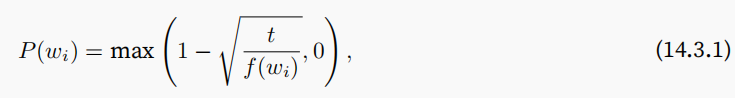

其中f(wi)是wi的词数与数据集中的总词数的⽐率，常量t是超参数（在实验中为10−4）。我们可以看到，只有
当相对⽐率f(wi) > t时，（⾼频）词wi才能被丢弃，且该词的相对⽐率越⾼，被丢弃的概率就越⼤。



In [5]:
#@save
def subsample(sentences, vocab):
    """下采样⾼频词"""
    # 排除未知词元'<unk>'
    sentences = [[token for token in line if vocab[token] != vocab.unk]
                 for line in sentences]
    counter = d2l.count_corpus(sentences)
    num_tokens = sum(counter.values())

    # 如果在下采样期间保留词元，则返回True
    def keep(token):
        return(random.uniform(0, 1) <
            math.sqrt(1e-4 / counter[token] * num_tokens))
    return ([[token for token in line if keep(token)] for line in sentences],
            counter)

subsampled, counter = subsample(sentences, vocab)

print(counter)

Counter({'the': 50770, 'N': 32481, 'of': 24400, 'to': 23638, 'a': 21196, 'in': 18000, 'and': 17474, "'s": 9784, 'that': 8931, 'for': 8927, '$': 7541, 'is': 7337, 'it': 6112, 'said': 6027, 'on': 5650, 'by': 4915, 'at': 4894, 'as': 4833, 'from': 4724, 'million': 4627, 'with': 4585, 'mr.': 4326, 'was': 4073, 'be': 3923, 'are': 3914, 'its': 3846, 'he': 3632, 'but': 3541, 'has': 3494, 'an': 3477, "n't": 3388, 'will': 3270, 'have': 3245, 'new': 2793, 'or': 2704, 'company': 2680, 'they': 2562, 'this': 2438, 'year': 2379, 'which': 2362, 'would': 2308, 'about': 2220, 'says': 2092, 'more': 2065, 'were': 2009, 'market': 2005, 'billion': 1881, 'his': 1852, 'had': 1850, 'their': 1838, 'up': 1785, 'u.s.': 1774, 'one': 1764, 'than': 1731, 'who': 1695, 'some': 1668, 'been': 1667, 'also': 1617, 'stock': 1611, 'other': 1566, 'share': 1511, 'not': 1451, 'we': 1397, 'corp.': 1288, 'if': 1281, 'when': 1272, 'i': 1262, 'last': 1255, 'president': 1246, 'shares': 1246, 'years': 1241, 'all': 1227, 'first': 118

下⾯的代码⽚段绘制了下采样前后每句话的词元数量的直⽅图。正如预期的那样，下采样通过删除⾼频词来
显著缩短句⼦，这将使训练加速。

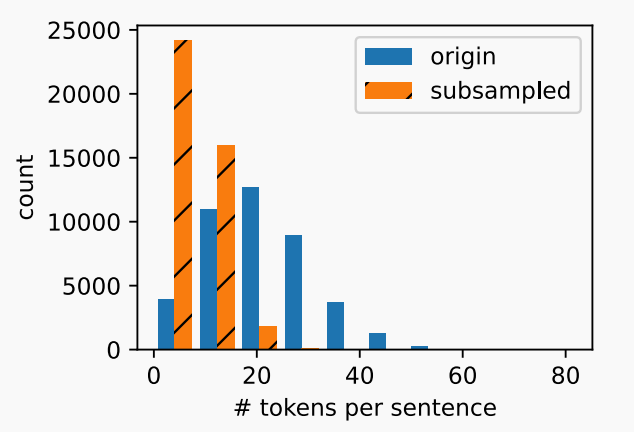

对于单个词元，⾼频词“the”的采样率不到1/20。

In [6]:
def compare_counts(token):
    return (f'"{token}"的数量：'
            f'之前={sum([l.count(token) for l in sentences])}, '
            f'之后={sum([l.count(token) for l in subsampled])}')
compare_counts('the')

'"the"的数量：之前=50770, 之后=2123'

In [7]:
# 相⽐之下，低频词“join”则被完全保留
compare_counts('join')

'"join"的数量：之前=45, 之后=45'

在下采样之后，我们将词元映射到它们在语料库中的索引。

In [8]:
corpus = [vocab[line] for line in subsampled]
corpus[:3]

[[], [392, 2132, 145, 275, 406], [5464, 3080, 1595]]

### 中心词和上下文词的提取
下 ⾯ 的get_centers_and_contexts函 数 从corpus中 提 取 所 有 中 ⼼ 词 及 其 上 下 ⽂ 词。 它 随 机 采
样1到max_window_size之间的整数作为上下⽂窗⼝。对于任⼀中⼼词，与其距离不超过采样上下⽂窗
⼝⼤⼩的词为其上下⽂词。

In [9]:
#@save
def get_centers_and_contexts(corpus, max_window_size):
    """返回跳元模型中的中⼼词和上下⽂词"""
    centers, contexts = [], []
    for line in corpus:
        # 要形成“中⼼词-上下⽂词”对，每个句⼦⾄少需要有2个词
        if len(line) < 2:
            continue
        centers += line
        for i in range(len(line)): # 上下⽂窗⼝中间i
            window_size = random.randint(1, max_window_size)
            indices = list(range(max(0, i - window_size),
                                min(len(line), i + 1 + window_size)))
            # 从上下⽂词中排除中⼼词
            indices.remove(i)
            contexts.append([line[idx] for idx in indices])
    return centers, contexts

接下来，我们创建⼀个⼈⼯数据集，分别包含7个和3个单词的两个句⼦。设置最⼤上下⽂窗⼝⼤⼩为2，并打
印所有中⼼词及其上下⽂词。

In [10]:
tiny_dataset = [list(range(7)), list(range(7, 10))]
print('数据集', tiny_dataset)
for center, context in zip(*get_centers_and_contexts(tiny_dataset, 2)):
    print('中⼼词', center, '的上下⽂词是', context)

数据集 [[0, 1, 2, 3, 4, 5, 6], [7, 8, 9]]
中⼼词 0 的上下⽂词是 [1, 2]
中⼼词 1 的上下⽂词是 [0, 2]
中⼼词 2 的上下⽂词是 [1, 3]
中⼼词 3 的上下⽂词是 [1, 2, 4, 5]
中⼼词 4 的上下⽂词是 [2, 3, 5, 6]
中⼼词 5 的上下⽂词是 [4, 6]
中⼼词 6 的上下⽂词是 [5]
中⼼词 7 的上下⽂词是 [8]
中⼼词 8 的上下⽂词是 [7, 9]
中⼼词 9 的上下⽂词是 [8]


在PTB数据集上进⾏训练时，我们将最⼤上下⽂窗⼝⼤⼩设置为5。下⾯提取数据集中的所有中⼼词及其上下
⽂词。

In [11]:
all_centers, all_contexts = get_centers_and_contexts(corpus, 5)
f'# “中⼼词-上下⽂词对”的数量: {sum([len(contexts) for contexts in all_contexts])}'

'# “中⼼词-上下⽂词对”的数量: 1504233'

### 负采样
我们使⽤负采样进⾏近似训练。为了根据预定义的分布对噪声词进⾏采样，我们定义以下RandomGenerator类，
其中（可能未规范化的）采样分布通过变量sampling_weights传递。

In [12]:
#@save
class RandomGenerator:
    """根据n个采样权重在{1,...,n}中随机抽取"""
    def __init__(self, sampling_weights):
        # Exclude
        self.population = list(range(1, len(sampling_weights) + 1))
        self.sampling_weights = sampling_weights
        self.candidates = []
        self.i = 0
    def draw(self):
        if self.i == len(self.candidates):
            # 缓存k个随机采样结果
            self.candidates = random.choices(
                self.population, self.sampling_weights, k=10000)
            self.i = 0
        self.i += 1
        return self.candidates[self.i - 1]

例如，我们可以在索引1、2和3中绘制10个随机变量X，采样概率为P(X = 1) = 2/9, P(X = 2) = 3/9和P(X =
3) = 4/9，如下所⽰。

In [13]:
#@save
generator = RandomGenerator([2, 3, 4])
[generator.draw() for _ in range(10)]

[2, 2, 3, 1, 3, 2, 2, 3, 1, 2]

对于⼀对中⼼词和上下⽂词，我们随机抽取了K个（实验中为5个）噪声词。根据word2vec论⽂中的建议，将
噪声词w的采样概率P(w)设置为其在字典中的相对频率，其幂为0.75 (Mikolov et al., 2013)。

In [14]:
#@save
def get_negatives(all_contexts, vocab, counter, K):
    """返回负采样中的噪声词"""
    # 索引为1、2、...（索引0是词表中排除的未知标记）
    sampling_weights = [counter[vocab.to_tokens(i)]**0.75
                        for i in range(1, len(vocab))]
    all_negatives, generator = [], RandomGenerator(sampling_weights)
    for contexts in all_contexts:
        negatives = []
        while len(negatives) < len(contexts) * K:
            neg = generator.draw()
            # 噪声词不能是上下⽂词
            if neg not in contexts:
                negatives.append(neg)
        all_negatives.append(negatives)
    return all_negatives

all_negatives = get_negatives(all_contexts, vocab, counter, 5)

### 小批量加载训练实例
在提取所有中⼼词及其上下⽂词和采样噪声词后，将它们转换成⼩批量的样本，在训练过程中可以迭代加载。
在⼩批量中，ith个样本包括中⼼词及其ni个上下⽂词和mi个噪声词。由于上下⽂窗⼝⼤⼩不同，ni + mi对于
不同的i是不同的。因此，对于每个样本，我们在contexts_negatives个变量中将其上下⽂词和噪声词连结起
来，并填充零，直到连结⻓度达到maxi ni + mi(max_len)。为了在计算损失时排除填充，我们定义了掩码变
量masks。在masks中的元素和contexts_negatives中的元素之间存在⼀⼀对应关系，其中masks中的0（否则
为1）对应于contexts_negatives中的填充。

为了区分正反例，我们在contexts_negatives中通过⼀个labels变量将上下⽂词与噪声词分开。类似于masks，
在labels中的元素和contexts_negatives中的元素之间也存在⼀⼀对应关系，其中labels中的1（否则为0）对
应于contexts_negatives中的上下⽂词的正例。
上述思想在下⾯的batchify函数中实现。其输⼊data是⻓度等于批量⼤⼩的列表，其中每个元素是由中⼼
词center、其上下⽂词context和其噪声词negative组成的样本。此函数返回⼀个可以在训练期间加载⽤于
计算的⼩批量，例如包括掩码变量。

In [15]:
#@save
def batchify(data):
    """返回带有负采样的跳元模型的⼩批量样本"""
    max_len = max(len(c) + len(n) for _, c, n in data)
    centers, contexts_negatives, masks, labels = [], [], [], []
    for center, context, negative in data:
        cur_len = len(context) + len(negative)
        centers += [center]
        contexts_negatives += \
            [context + negative + [0] * (max_len - cur_len)]
        masks += [[1] * cur_len + [0] * (max_len - cur_len)]
        labels += [[1] * len(context) + [0] * (max_len - len(context))]
    return (torch.tensor(centers).reshape((-1, 1)), torch.tensor(
        contexts_negatives), torch.tensor(masks), torch.tensor(labels))

使⽤⼀个⼩批量的两个样本来测试此函数。

In [16]:
x_1 = (1, [2, 2], [3, 3, 3, 3])
x_2 = (1, [2, 2, 2], [3, 3])
batch = batchify((x_1, x_2))
names = ['centers', 'contexts_negatives', 'masks', 'labels']
for name, data in zip(names, batch):
    print(name, '=', data)

centers = tensor([[1],
        [1]])
contexts_negatives = tensor([[2, 2, 3, 3, 3, 3],
        [2, 2, 2, 3, 3, 0]])
masks = tensor([[1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 0]])
labels = tensor([[1, 1, 0, 0, 0, 0],
        [1, 1, 1, 0, 0, 0]])


### 整合代码
定义了读取PTB数据集并返回数据迭代器和词表的load_data_ptb函数。


In [17]:
#@save
def load_data_ptb(batch_size, max_window_size, num_noise_words):
    """下载PTB数据集，然后将其加载到内存中"""
    #num_workers = d2l.get_dataloader_workers()
    sentences = read_ptb()
    vocab = d2l.Vocab(sentences, min_freq=10)
    subsampled, counter = subsample(sentences, vocab)
    corpus = [vocab[line] for line in subsampled]
    all_centers, all_contexts = get_centers_and_contexts(
        corpus, max_window_size)
    all_negatives = get_negatives(
        all_contexts, vocab, counter, num_noise_words)

    class PTBDataset(torch.utils.data.Dataset):
        def __init__(self, centers, contexts, negatives):
            assert len(centers) == len(contexts) == len(negatives)
            self.centers = centers
            self.contexts = contexts
            self.negatives = negatives

        def __getitem__(self, index):
            return (self.centers[index], self.contexts[index],
                    self.negatives[index])
        
        def __len__(self):
            return len(self.centers)
        
    dataset = PTBDataset(all_centers, all_contexts, all_negatives)
    data_iter = torch.utils.data.DataLoader(
        dataset, batch_size, shuffle=True,
        collate_fn=batchify)
    return data_iter, vocab

In [18]:
# 打印数据迭代器的第⼀个⼩批量。
data_iter, vocab = load_data_ptb(512, 5, 5)
for batch in data_iter:
    for name, data in zip(names, batch):
        print(name, 'shape:', data.shape)
    break

centers shape: torch.Size([512, 1])
contexts_negatives shape: torch.Size([512, 60])
masks shape: torch.Size([512, 60])
labels shape: torch.Size([512, 60])


## 小结
* ⾼频词在训练中可能不是那么有⽤。我们可以对他们进⾏下采样，以便在训练中加快速度。
* 为了提⾼计算效率，我们以⼩批量⽅式加载样本。我们可以定义其他变量来区分填充标记和⾮填充标记，以及正例和负例。